+ https://xilinx.github.io/Vitis_Libraries/quantitative_finance/2020.1/methods/cf-ht.html

In [1]:
%run key_imports.py

In [78]:
from heston import cir_step, heston_step, heston_call_quad, heston_cdf, heston_density_quad
from utils import diagnosis_pde, diagnosis_pred
from importlib import reload
import heston
reload(heston)
import warnings
from tqdm.notebook import tqdm
tqdm.pandas()
warnings.filterwarnings("ignore")
tf.autograph.set_verbosity(0)

ImportError: cannot import name 'heston_density_quad' from 'heston' (/Users/chris/Downloads/msc-thesis/examples/heston.py)

# Heston


- ✅ fix heston call price
- ✅ surface plots
- ✅ implied vol plots
- ✅ complete heston greeks

# Simulate heston samples

+ Generate initial params, use $(S_{i, t}/K - 1.0)^{+}, t$ as target, vary time-to-maturity, fix all other parameters
    + reduces variation in state X
+ Generate initial params, use $(S_{T}/K - 1.0)^{+}$ as target
    + 
+ Fix terminal moneyness $S_{T}/K$, and go backwards?
+ Fix initial moneyness $(S_{0}/K)$, and go forwards?
+ Labels: 
    + "True" labels (Characteristic Function)
    + MC samples

(131072, 7) (131072,)


<AxesSubplot:>

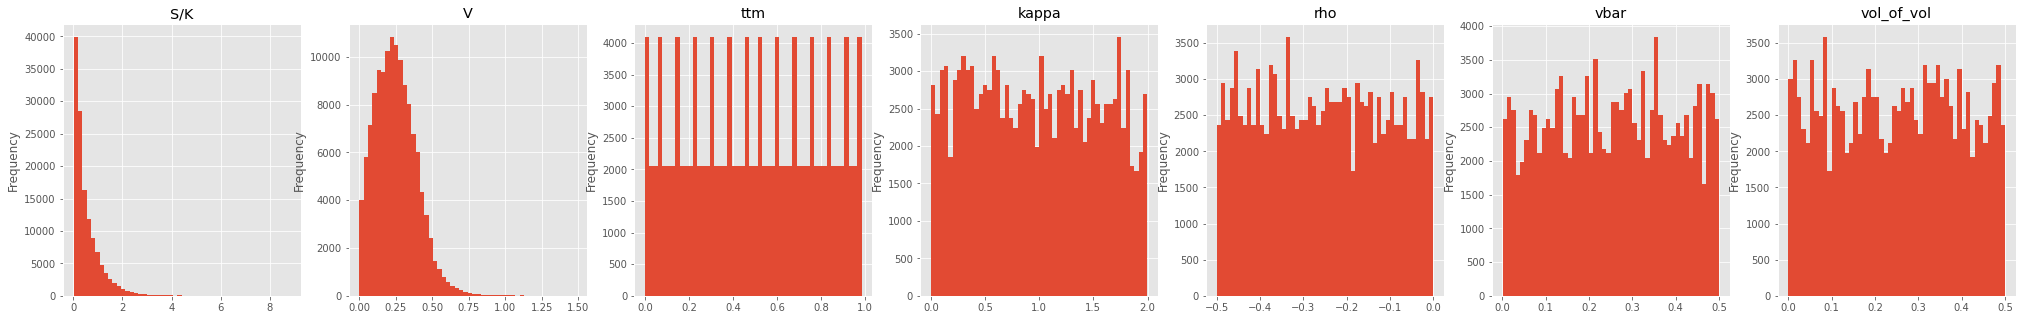

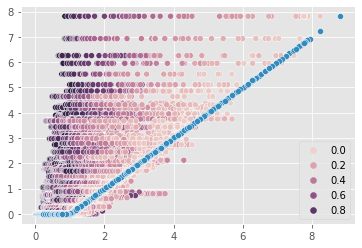

In [26]:
"""
Fix Random Seed
"""
SEED = 42
rng = default_rng(SEED)




"""
Fix Terminal maturity
"""

T = 1
N_TIMES = 64
dt = T / N_TIMES
ts = np.linspace(dt, T, N_TIMES)

"""
Define State Variables
"""
N_SAMPLES = 2048
SK = rng.uniform(-3, 0, N_SAMPLES).reshape((-1, 1))
rho = rng.uniform(-0.5, 0.0, N_SAMPLES).reshape((-1, 1))
kappa = rng.uniform(0, 2, N_SAMPLES)
vbar = rng.uniform(0, 0.5, N_SAMPLES)
vol_of_vol = rng.uniform(0, 0.5, N_SAMPLES)
V0 = rng.uniform(0, 0.5, N_SAMPLES)


"""
Define Brownian Increments
"""
W_v = rng.standard_normal((N_SAMPLES, N_TIMES)) * np.sqrt(dt)
W_s = rng.standard_normal((N_SAMPLES, N_TIMES)) * np.sqrt(dt)


"""
Simulate St, Vt paths
"""
Sts = np.zeros((N_SAMPLES, N_TIMES))
Vts = np.zeros((N_SAMPLES, N_TIMES))

Vts[:,0] = cir_step(V0, kappa, vbar, dt, vol_of_vol, W_v[:,0])
Sts[:, 0] = heston_step(np.exp(SK[:,0]), dt, V0, W_s[:,0], W_v[:,0], rho)
for i in range(1, N_TIMES):
    Vts[:, i] = cir_step(Vts[:, i - 1], kappa, vbar, dt, vol_of_vol, W_v[:, i])
    Sts[:, i] = heston_step(Sts[:,i-1], dt, V0, W_s[:,i], W_v[:, i], rho)

    
# np.repeat(ts, N_SAMPLES).reshape((-1, N_SAMPLES)).T.reshape(-1)
# np.repeat(kappa, N_TIMES)

"""
Combine to create dataset
"""

feat_names = ['S/K', 'V','ttm', 'kappa', 'rho', 'vbar','vol_of_vol']
f_to_i = lambda x: feat_names.index(x)


# Fix initial parameters, use payoffs of futures values, vary TTM
# y = np.maximum(Sts - 1.0, 0).reshape(-1)
# ys = y.copy()
# Xs = np.vstack([np.repeat(SK, N_TIMES),
#                 np.repeat(V0, N_TIMES),
#                 np.repeat(ts, N_SAMPLES).reshape((-1, N_SAMPLES)).T.reshape(-1),
#                 np.repeat(kappa, N_TIMES),
#                 np.repeat(rho, N_TIMES),
#                 np.repeat(vbar, N_TIMES),
#                 np.repeat(vol_of_vol, N_TIMES),
#                 ]).T

# Fix terminal payoff, go forward in time
y = np.maximum(Sts[:,-1] - 1, 0)
Xs = np.vstack([Sts.reshape(-1),
                Vts.reshape(-1),
                np.repeat(T - ts, N_SAMPLES).reshape((-1, N_SAMPLES)).T.reshape(-1),
                np.repeat(kappa, N_TIMES),
                np.repeat(rho, N_TIMES),
                np.repeat(vbar, N_TIMES),
                np.repeat(vol_of_vol, N_TIMES),
                ]).T
ys = np.repeat(y, N_TIMES)
X_df = pd.DataFrame(Xs, columns = feat_names)


print(Xs.shape, ys.shape)
assert Xs.shape[0] == ys.shape[0]

"""
Visualise data
"""
# Distributions
fig, ax = plt.subplots(figsize=(5 * X_df.shape[1], 5), ncols = X_df.shape[1])
for i in range(X_df.shape[1]):
    X_df.iloc[:, i].plot(kind = 'hist', ax = ax[i], bins = 50)
    ax[i].set_title(feat_names[i])
    
# sample payoff, intrinsic val v S/K
fig, ax = plt.subplots()
sns.scatterplot(x = Xs[:,f_to_i("S/K")], y = ys, hue = Xs[:, f_to_i("ttm")])
sns.scatterplot(x = Xs[:,f_to_i("S/K")], y = np.maximum(Xs[:,f_to_i("S/K")] - 1.0, 0))

# Model - Call Task

In [27]:
N_SEEDS = 1
EPOCHS = 10
BATCH_SIZE = 128
N_FEATS = Xs.shape[1]

from tensorflow.keras.optimizers import Adam, SGD
lr = 1e-3
opt = Adam(learning_rate=lr)

preds = np.zeros((Xs.shape[0], N_SEEDS))
models = []

HIDDEN_UNITS = 30
layer_template = Dense(HIDDEN_UNITS, activation='softplus', kernel_constraint=None, kernel_initializer='he_normal')
output_layer = Dense(1, activation='linear', kernel_constraint='non_neg', kernel_initializer='he_normal')

print(np.mean((ys - ys.mean() ** 2)))
for i in range(N_SEEDS):
    control_var = 0
    models += [ffn_network(N_FEATS, 1, layer_template, output_layer, seed = i)]
    models[i].compile(optimizer='Adam', loss='MSE')
    history = models[i].fit(Xs, ys - control_var, epochs=EPOCHS, batch_size = BATCH_SIZE)
    preds[:,i] =models[i].predict(Xs).reshape(-1) - control_var

0.21135704349044795
Epoch 1/10
1024/1024 [==============================] - 1s 991us/step - loss: 1.0070
Epoch 2/10
1024/1024 [==============================] - 1s 990us/step - loss: 0.2602
Epoch 3/10
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2136
Epoch 4/10
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2039
Epoch 5/10
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2004
Epoch 6/10
1024/1024 [==============================] - 1s 1ms/step - loss: 0.1960
Epoch 7/10
1024/1024 [==============================] - 1s 992us/step - loss: 0.1925
Epoch 8/10
1024/1024 [==============================] - 1s 996us/step - loss: 0.1907
Epoch 9/10
1024/1024 [==============================] - 1s 1ms/step - loss: 0.1899
Epoch 10/10
1024/1024 [==============================] - 1s 1ms/step - loss: 0.1895


{'mean': 0.55954456, 'l1': 0.7392717, 'l2': 0.8424747, 'l_inf': 1.5342878}


Text(0.5, 1.0, 'Gamma')

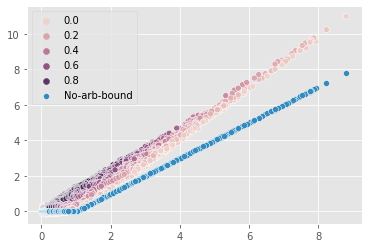

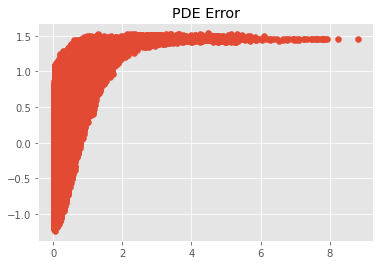

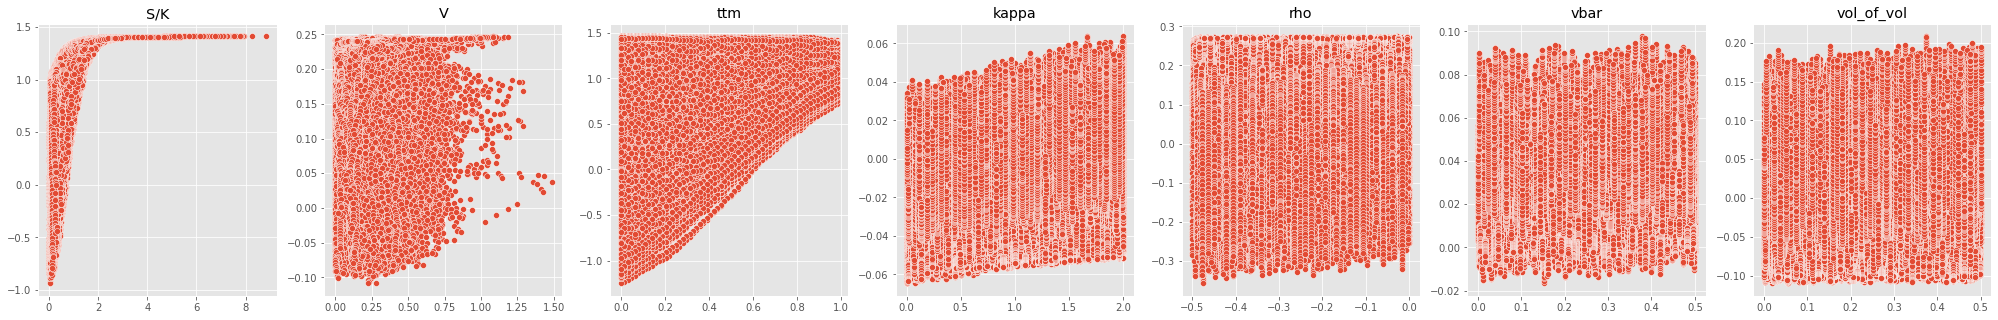

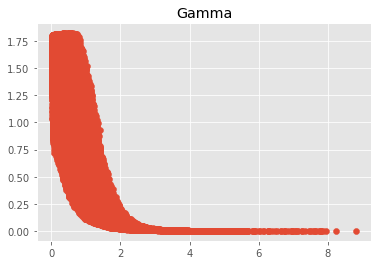

In [28]:
"""
Prediction Errors
"""
model = models[0]
intrinsic_val = np.maximum(Xs[:, f_to_i("S/K")] - 1.0, 0)
preds = models[0].predict(Xs)
try:
    preds = preds.reshape(-1)
except:
    pass
# preds = model.predict([Xs for i in range(N_SEEDS)])
# preds = preds.reshape(-1)

sns.scatterplot(Xs[:,f_to_i("S/K")], preds, hue = Xs[:, f_to_i("ttm")], label=None)
sns.scatterplot(x = Xs[:,f_to_i("S/K")], y = np.maximum(Xs[:,f_to_i("S/K")] - 1.0, 0), label = "No-arb-bound");
diagnosis_pred(intrinsic_val, preds, intrinsic_val)


"""
Compute all Gradients, Hessian
"""
Xs = Xs.astype(np.float32)
X_tensor = tf.Variable(Xs)
with tf.GradientTape(persistent=True) as tape2:
    with tf.GradientTape(persistent=True) as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("S/K")], X_tensor)
    hessian2 = tape2.gradient(grads[:, f_to_i("V")], X_tensor)
    
"""
Error in PDE operator (Dynamic Arbitrage)
"""
PDE_err = (
grads[:, f_to_i("ttm")]
- (grads[:, f_to_i("V")] * Xs[:, f_to_i("kappa")] * (Xs[:, f_to_i("vbar")] - Xs[:, f_to_i("V")])
+ Xs[:, f_to_i("rho")] * Xs[:, f_to_i("vol_of_vol")] * Xs[:, f_to_i("V")] * Xs[:, f_to_i("S/K")] * hessian1[:, f_to_i("V")]
+ 0.5 * (Xs[:, f_to_i("S/K")] ** 2) * Xs[:, f_to_i("V")] * hessian1[:, f_to_i("S/K")]
+ 0.5 * Xs[:, f_to_i("V")] * (Xs[:, f_to_i("vol_of_vol")] ** 2) * hessian2[:, f_to_i("V")]
))

# PDE_err = (
# grads[:, f_to_i("ttm")]
# - (grads[:, f_to_i("V")] * Xs[:, f_to_i("kappa")] * (Xs[:, f_to_i("vbar")] - Xs[:, f_to_i("V")])
# + Xs[:, f_to_i("rho")] * Xs[:, f_to_i("vol_of_vol")] * Xs[:, f_to_i("V")] * hessian1[:, f_to_i("V")]
# + 0.5 * Xs[:, f_to_i("V")] * hessian1[:, f_to_i("log(S/K)")]
# - Xs[:, f_to_i("V")] * grads[:, f_to_i("log(S/K)")]
# + 0.5 * Xs[:, f_to_i("V")] * (Xs[:, f_to_i("vol_of_vol")] ** 2) * hessian2[:, f_to_i("V")]
# ))

print(diagnosis_pde(PDE_err))
fig, ax = plt.subplots()
ax.scatter(Xs[:, f_to_i("S/K")], PDE_err)
ax.set_title("PDE Error")

"""
Error in Greeks
"""
fig, ax = plt.subplots(ncols = Xs.shape[1], figsize=(5 * Xs.shape[1], 5))
for i in range(Xs.shape[1]):
    sns.scatterplot(x = Xs[:,i], y = grads[:, i], ax = ax[i])
    ax[i].set_title(feat_names[i])
    
    
fig, ax = plt.subplots()
ax.scatter(Xs[:, f_to_i("S/K")], hessian1[:, f_to_i("S/K")])
ax.set_title("Gamma")

+ fix $X_{1} = (S_{T} / K)$. Scale $\frac{S_{t_{n}}}{K} = \frac{S_{T}}{X_{1}}$

$S_{t} = S_{t} + V_{t}S_{t} dW_{1, t}$

The Heston PDE is given by

$$V_{t} + \frac{vs^{2}V_{ss}}{2} + \rho \eta y \cdot V_{sy} + \frac{\eta^{2}y V_{yy}}{2} +rsV_{s} -rV + \lambda(\theta - y)V_{y} = 0$$

considering a forward $F = e^{r(T - t)}S_{t}$ instead of $S$, time to maturity instead of $t$ we have:

$$V_{\tau} = \frac{V_{ff} yf^{2}}{2} + \rho \eta y V_{fy} + \frac{\eta^{2}y V_{yy}}{2} + \kappa(\theta - y)V_{y}$$

Then let $x = \log(F/K)$. Then the PDE is given by:

$$d\log(F_{t}) = -\frac{V_{t}}{2}dt + \sqrt{V_{t}}dW_{1, t}$$

$$V_{\tau} = \frac{V_{xx} yf^{2}}{2} + \rho \eta y V_{fy} + \frac{\eta^{2}V_{yy}}{2} + \kappa(\theta - y)V_{y}$$

In [3]:
# def f(x):
#     # return (tf.math.exp(x) - 1) * (0.5 * (tf.sign(x) - 1)) + x * (0.5 * (tf.sign(x) + 1))
#     # return 1 / (1 + tf.math.exp(-x))
#     # return tf.math.log(1 + tf.math.exp(x))
#     return tf.math.exp(-0.5 * x ** 2)

# X = np.linspace(-20, 20, 1000).astype(np.float32)
# X_tensor = tf.Variable(X)
# with tf.GradientTape() as tape3:
#     with tf.GradientTape() as tape2:
#         with tf.GradientTape() as tape:
#             output = f(X_tensor)
#             grads = tape.gradient(output, X_tensor)
#             hessian = tape2.gradient(grads, X_tensor)
#             d3 = tape3.gradient(hessian, X_tensor)
# plt.plot(X, output)
# plt.plot(X, grads)
# plt.plot(X, hessian)
# plt.plot(X, d3)

In [38]:
# from scipy.integrate import quad
# def heston_phi(k, tau, v, vbar, lambd, eta, rho):
# 	"""Heston's model characteristic function
# 	rms have the parameters in this order: lambd, rho, eta, vbar
#     lambd: kappa, mean reversion speed
#     tau: time-to-maturity
#     eta: vol-of-vol
#     rho: correlation between brownian motions
# 	"""
# 	b = lambd + 1j * rho * eta * k
# 	d = np.sqrt( b ** 2 + (eta ** 2) * k * (k - 1j) )
# 	g = (b - d) / (b + d)
# 	T_m = (b - d) / (eta**2)
# 	T = T_m * ( 1 - np.exp(-d*tau) )/( 1 - g * np.exp(-d*tau) )
# 	W = lambd * vbar * (tau * T_m - 2 * np.log( ( 1 - g * np.exp(-d * tau) )/(1 - g))/(eta ** 2))
	
# 	return np.exp(W + v*T)

# def heston_phi_transform(tau, x, v, vbar, lambd, eta, rho):
# 	integrand = lambda k: 2 * np.real(np.exp(-1j*k*x) * heston_phi(k + 0.5*1j, tau, v, vbar, lambd, eta, rho) ) / (k ** 2 + 0.25)
# 	return quad(integrand, 0, 100)[0]

# def heston_call(F, K, tau, v, vbar, lambd, eta, rho):
# 	'''Heston call'''
# 	x = np.log(F/K)
# 	integral = heston_phi_transform(tau, x, v, vbar, lambd, eta, rho)
# 	return F - K * integral

# plt.plot([heston_call(2, k, T, V0, vbar[0], kappa[0], vol_of_vol[0], rho[0]) for k in np.linspace(1e-3, 5)])

# Digital Pricing

## Check if Heston Characteristic Function seems well implemented

In [ ]:
"""
CDF should get close to a dirac delta function as ttm -> 0
"""
for tau in tqdm(np.linspace(1e-2, 2, 10)):
    plt.plot(xs, [heston_cdf(x, tau, v = 0.2, kappa = 0, vbar = 0.2, vol_of_vol=0.2, rho = 0) for x in xs])

In [39]:
ps = np.array([f(x, tau, v = 0.2, kappa = 0, vbar = 0.2, vol_of_vol=0.2, rho = 0) for x in xs])
eps = 1e-6
ps2 = np.array([f(x + eps, tau, v = 0.2, kappa = 0, vbar = 0.2, vol_of_vol=0.2, rho = 0) for x in xs])
plt.plot(xs, (ps2 - ps) / 1e-6)

NameError: name 'xs' is not defined

In [37]:
preds = X_df.progress_apply(lambda x: heston_cdf(np.log(x['S/K']), 
                       tau = x['ttm'], 
                       v = x['V'], 
                       kappa = x['kappa'], 
                       vbar = x['vbar'], 
                       vol_of_vol=x['vol_of_vol'], 
                       rho = x['rho']), axis = 1)

X_df2 = X_df.copy()
X_df2['digital'] = preds
X_df2.loc[X_df2['ttm'] == 0, 'digital'] = (X_df2.loc[X_df2['ttm'] == 0, 'S/K'] > 1) * 1
X_df2.loc[X_df2['digital'] < 0] = 0
X_df2.to_csv("heston_dataset.csv", index=False)

  0%|          | 0/131072 [00:00<?, ?it/s]

In [134]:
Xs = X_df2.drop('digital', axis = 1).values.astype(np.float320
ys = X_df2['digital'].values.astype(np.float32)

In [232]:
N_SEEDS = 1
EPOCHS = 10
BATCH_SIZE = 128
N_FEATS = Xs.shape[1]

from tensorflow.keras.optimizers import Adam, SGD
lr = 1e-3
opt = Adam(learning_rate=lr)

preds = np.zeros((Xs.shape[0], N_SEEDS))
models = []

HIDDEN_UNITS = 30
N_LAYERS = 2


layer_template = lambda:  Dense(HIDDEN_UNITS, activation='softplus', kernel_constraint=None, kernel_initializer='he_normal')
output_layer = lambda: Dense(1, activation='sigmoid', kernel_initializer='he_normal')

print(np.mean((ys - ys.mean() ** 2)))
for i in range(N_SEEDS):
    control_var = 0
    models += [ffn_network(N_FEATS, N_LAYERS, layer_template, output_layer, seed = i)]
    models[i].compile(optimizer='Adam', loss='MSE')
    history = models[i].fit(Xs, ys - control_var, epochs=EPOCHS, batch_size = BATCH_SIZE)
    preds[:,i] =models[i].predict(Xs).reshape(-1) - control_var

0.13724367696655468
Epoch 1/10
1024/1024 [==============================] - 2s 1ms/step - loss: 0.0076
Epoch 2/10
1024/1024 [==============================] - 1s 1ms/step - loss: 0.0023
Epoch 3/10
1024/1024 [==============================] - 1s 1ms/step - loss: 0.0020
Epoch 4/10
1024/1024 [==============================] - 1s 1ms/step - loss: 0.0015
Epoch 5/10
1024/1024 [==============================] - 1s 1ms/step - loss: 9.3519e-04
Epoch 6/10
1024/1024 [==============================] - 1s 1ms/step - loss: 6.6881e-04
Epoch 7/10
1024/1024 [==============================] - 1s 1ms/step - loss: 5.9534e-04
Epoch 8/10
1024/1024 [==============================] - 1s 1ms/step - loss: 5.5412e-04
Epoch 9/10
1024/1024 [==============================] - 1s 1ms/step - loss: 5.3120e-04
Epoch 10/10
1024/1024 [==============================] - 1s 1ms/step - loss: 5.0919e-04


Text(0.5, 1.0, 'Gamma')

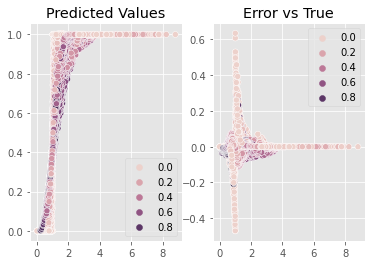

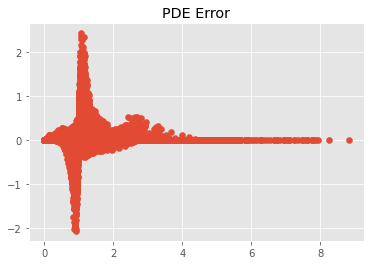

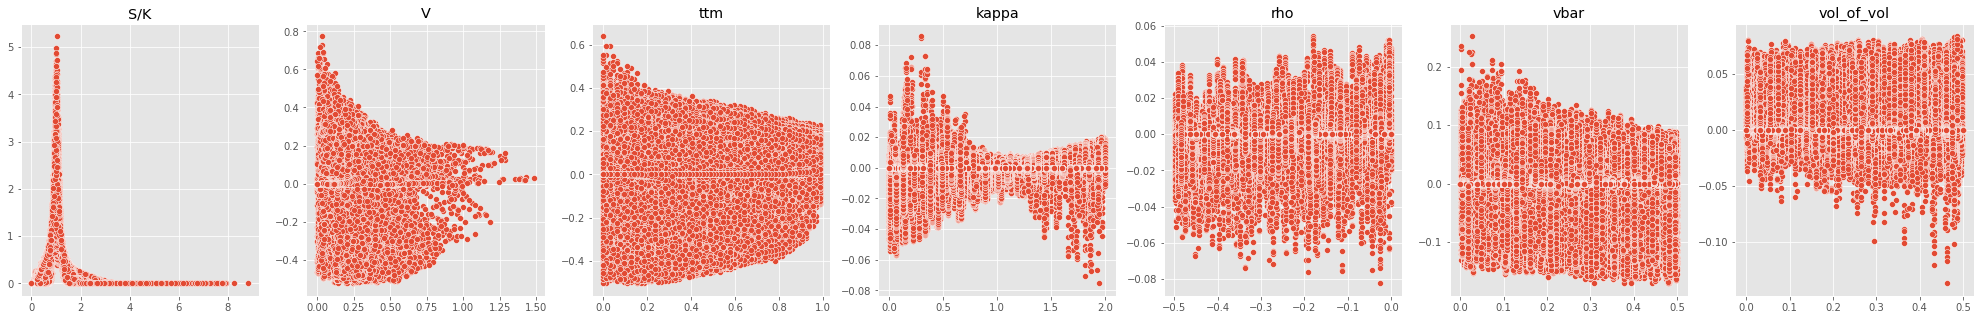

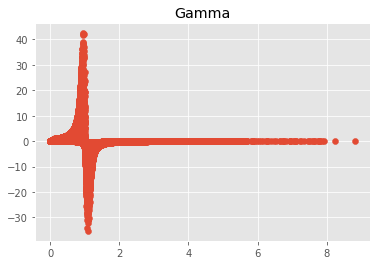

In [244]:
"""
Prediction Errors
"""
model = models[0]
true = ys
preds = models[0].predict(Xs)
try:
    preds = preds.reshape(-1)
except:
    pass
# preds = model.predict([Xs for i in range(N_SEEDS)])
# preds = preds.reshape(-1)

fig, ax = plt.subplots(ncols = 2)
sns.scatterplot(Xs[:,f_to_i("S/K")], true, hue = Xs[:, f_to_i("ttm")], label=None, ax = ax[0])
sns.scatterplot(Xs[:,f_to_i("S/K")], true - preds, hue = Xs[:, f_to_i("ttm")], label=None, ax = ax[1])
ax[1].set_title("Error vs True")
ax[0].set_title("Predicted Values")


"""
Compute all Gradients, Hessian
"""
Xs = Xs.astype(np.float32)
X_tensor = tf.Variable(Xs)
with tf.GradientTape(persistent=True) as tape2:
    with tf.GradientTape(persistent=True) as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("S/K")], X_tensor)
    hessian2 = tape2.gradient(grads[:, f_to_i("V")], X_tensor)
    
"""
Error in PDE operator (Dynamic Arbitrage)
"""
PDE_err = (
grads[:, f_to_i("ttm")]
- (grads[:, f_to_i("V")] * Xs[:, f_to_i("kappa")] * (Xs[:, f_to_i("vbar")] - Xs[:, f_to_i("V")])
+ Xs[:, f_to_i("rho")] * Xs[:, f_to_i("vol_of_vol")] * Xs[:, f_to_i("V")] * Xs[:, f_to_i("S/K")] * hessian1[:, f_to_i("V")]
+ 0.5 * (Xs[:, f_to_i("S/K")] ** 2) * Xs[:, f_to_i("V")] * hessian1[:, f_to_i("S/K")]
+ 0.5 * Xs[:, f_to_i("V")] * (Xs[:, f_to_i("vol_of_vol")] ** 2) * hessian2[:, f_to_i("V")]
))

# PDE_err = (
# grads[:, f_to_i("ttm")]
# - (grads[:, f_to_i("V")] * Xs[:, f_to_i("kappa")] * (Xs[:, f_to_i("vbar")] - Xs[:, f_to_i("V")])
# + Xs[:, f_to_i("rho")] * Xs[:, f_to_i("vol_of_vol")] * Xs[:, f_to_i("V")] * hessian1[:, f_to_i("V")]
# + 0.5 * Xs[:, f_to_i("V")] * hessian1[:, f_to_i("log(S/K)")]
# - Xs[:, f_to_i("V")] * grads[:, f_to_i("log(S/K)")]
# + 0.5 * Xs[:, f_to_i("V")] * (Xs[:, f_to_i("vol_of_vol")] ** 2) * hessian2[:, f_to_i("V")]
# ))


fig, ax = plt.subplots()
ax.scatter(Xs[:, f_to_i("S/K")], PDE_err)
ax.set_title("PDE Error")

"""
Error in Greeks
"""
fig, ax = plt.subplots(ncols = Xs.shape[1], figsize=(5 * Xs.shape[1], 5))
for i in range(Xs.shape[1]):
    sns.scatterplot(x = Xs[:,i], y = grads[:, i], ax = ax[i])
    ax[i].set_title(feat_names[i])
    
    
fig, ax = plt.subplots()
ax.scatter(Xs[:, f_to_i("S/K")], hessian1[:, f_to_i("S/K")])
ax.set_title("Gamma")

Text(0.5, 1.0, 'Implied density')

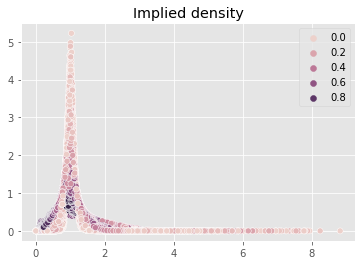

In [245]:
fig, ax = plt.subplots()
sns.scatterplot(x = Xs[:, f_to_i("S/K")], y = grads[:, f_to_i("S/K")], hue = Xs[:, f_to_i("ttm")])
ax.set_title("Implied density")

In [246]:
res = pd.concat([pd.DataFrame([diagnosis_pred(true, preds, 0)], index=[0]).add_prefix("pred_"),
           pd.DataFrame(diagnosis_pde(PDE_err), index = [0]).add_prefix("PDE_")], axis = 1)
res['monotonicity_error'] = np.mean(grads[:, f_to_i("S/K")] < 0)
display(res)

,pred_l1,pred_l2,pred_l_inf,pred_lower_bound_violation,PDE_mean,PDE_l1,PDE_l2,PDE_l_inf,monotonicity_error
0,0.007978,0.02185,0.634753,0.0,0.015793,0.05297,0.156748,2.436085,0.0


<AxesSubplot:xlabel='S/K', ylabel='digital'>

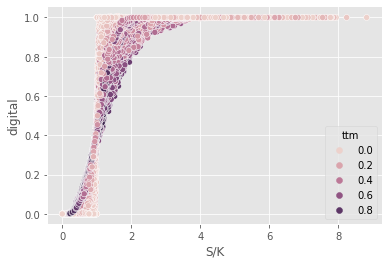

In [247]:
sns.scatterplot(X_df2['S/K'], X_df2['digital'], X_df2['ttm'])

+ Larger TTM values result should lead to a less steep sigmoidal curve
+ $\sigma(ax), T - t \rightarrow 0, a \rightarrow \infty$

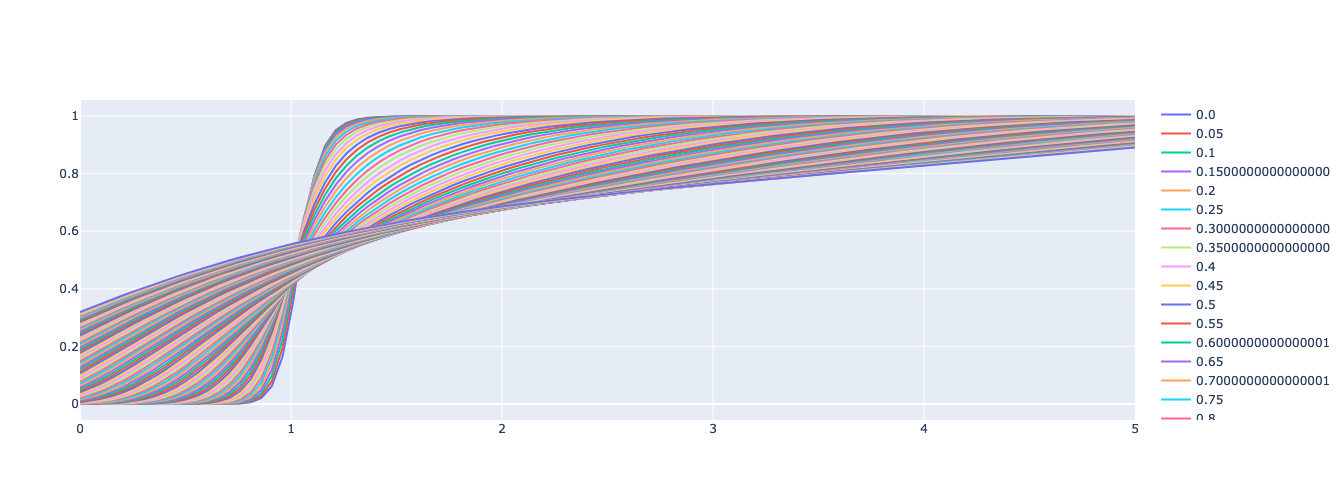

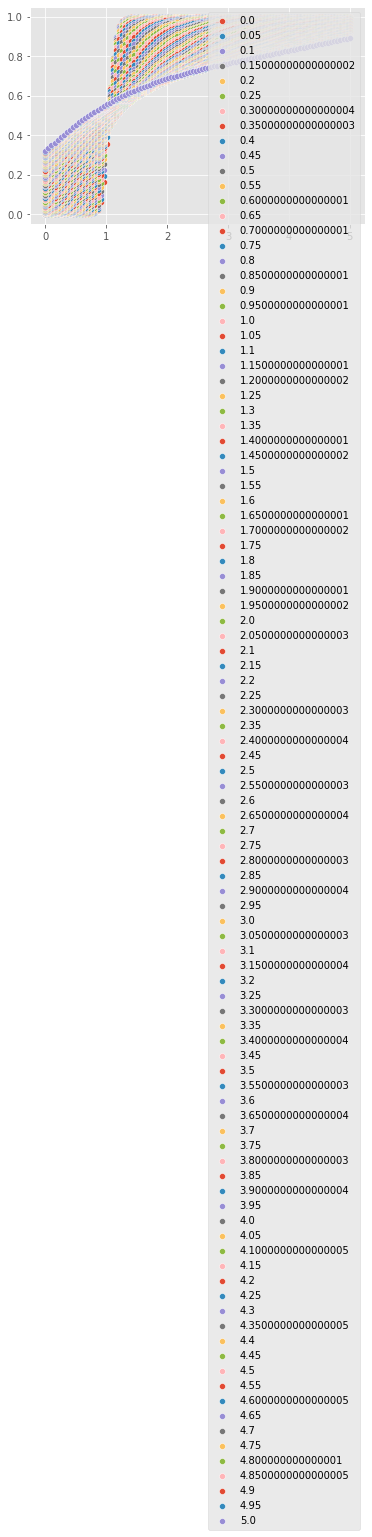

In [309]:
N_POINTS = 100
test_case = np.zeros((N_POINTS, N_FEATS))
X_space  = np.linspace(0, 5, N_POINTS)
test_case[:,0] = X_space

import plotly.graph_objects as go
fig = go.Figure()

fig2, ax = plt.subplots()
for t in np.linspace(0, 5, 101):
    test_case[:, 1] = t
    preds = model.predict(test_case).reshape(-1)
    sns.scatterplot(x = test_case[:,0],y =  preds, label=t)
    fig.add_trace(go.Scatter(x = test_case[:,0],y =  preds, name=t))
fig.update_layout(width=1000, height = 500)
fig.show()


$$\int_{K}^{\infty}(F/ K - 1)^{+} p(y)dy, y =  -x = log(K/F)$$

# Compute Europeans from Digitals

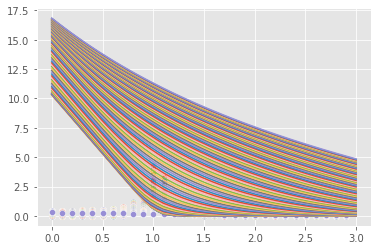

In [332]:

def grad(X_tensor):
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    return grads

N_POINTS = 1000
test_case = np.zeros((N_POINTS, N_FEATS))
X_space  = np.linspace(0, 100, N_POINTS)
test_case[:,0] = X_space


for t in np.linspace(0, 5, 101):
    X_tensor = tf.Variable(test_case)
    test_case[:, 1] = t
    density = grad(X_tensor)[:, f_to_i("S/K")].numpy()
    sns.scatterplot(X_tensor.numpy()[:,f_to_i("S/K")].reshape(-1)[:30], density.reshape(-1)[:30])
    dx =  np.diff(X_space)[0]
    # print(np.sum(density * dx))

    Ks = np.linspace(0 ,3)
    plt.plot(Ks, [np.sum(density * np.maximum(X_space - i, 0)) for i in Ks])

$K/F - 1$